<a href="https://colab.research.google.com/github/jokend1ng/jokend1ng/blob/jokend1ng-ml_LEANING/%D0%A1%D0%BE%D1%81%D1%82%D1%8F%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F%20%D1%81%D0%B5%D1%82%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Reshape,Input,BatchNormalization,Dropout
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,LeakyReLU


In [2]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()

x_train = x_train[y_train==7]
y_train = y_train[y_train==7]


11501568/11490434 [==============================] - 0s 0us/step


In [3]:
BUFFER_SIZE=x_train.shape[0]
BATCH_SIZE=100

BUFFER_SIZE=BUFFER_SIZE//BATCH_SIZE*BATCH_SIZE
x_train=x_train[:BUFFER_SIZE]
y_train=y_train[:BUFFER_SIZE]
print(x_train.shape,y_train.shape)

(6200, 28, 28) (6200,)


In [4]:
x_train=x_train/255
x_test=x_test/255

In [5]:
x_train=np.reshape(x_train,(len(x_train),28,28,1))
x_test=np.reshape(x_test,(len(x_test),28,28,1))

In [6]:
train_dataset=tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
hidden_dim=2

In [8]:
def dropout_and_batch():
    return Dropout(0.3)(BatchNormalization())

In [9]:
generator =tf.keras.Sequential([
  Dense(7*7*256,activation='relu',input_shape=(hidden_dim,)),
  BatchNormalization(),
  Reshape((7,7,256)),
  Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',activation='relu'),
  BatchNormalization(), 
  Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',activation='relu'),
  BatchNormalization(),  
  Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',activation='sigmoid')                             
])

In [10]:
discriminator=tf.keras.Sequential()
discriminator.add(Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28,28,1]))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(128,(5,5),strides=(2,2),padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Flatten())
discriminator.add(Dense(1))


In [11]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def generator_loss(fake_output):
    loss=cross_entropy(tf.ones_like(fake_output),fake_output)
    return loss

In [13]:
def discriminator_loss(real_output,fake_output):
    real_loss=cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss=real_loss+fake_loss
    return total_loss

In [14]:
generator_optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)


In [15]:
@tf.function
def train_step(images):
    noise=tf.random.normal([BATCH_SIZE,hidden_dim])

    with tf.GradientTape() as gen_tape,tf.GradientTape()as disc_tape:
        generated_images=generator(noise,training=True)

        real_output=discriminator(images,training=True)
        fake_output=discriminator(generated_images,training=True)

        gen_loss=generator_loss(fake_output)
        disc_loss=discriminator_loss(real_output,fake_output)

    gradients_of_generator=gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_of_discriminator=disc_tape.gradient(disc_loss,discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

    return gen_loss, disc_loss
    

In [16]:
def train(dataset, epochs):
  history = []
  MAX_PRINT_LABEL = 10
  th = BUFFER_SIZE // (BATCH_SIZE*MAX_PRINT_LABEL)
 
  for epoch in range(1, epochs+1):
    print(f'{epoch}/{EPOCHS}: ', end='')
 
    start = time.time()
    n = 0
 
    gen_loss_epoch = 0
    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      gen_loss_epoch += K.mean(gen_loss)
      if( n % th == 0): print('=', end='')
      n += 1
 
    history += [gen_loss_epoch/n]
    print(': '+str(history[-1]))
    print ('Время эпохи {} составляет {} секунд'.format(epoch + 1, time.time()-start))
     
  return history
   

1/20: ===========: tf.Tensor(1.5496659, shape=(), dtype=float32)
Время эпохи 2 составляет 77.8758704662323 секунд
2/20: ===========: tf.Tensor(2.6481752, shape=(), dtype=float32)
Время эпохи 3 составляет 66.80544853210449 секунд
3/20: ===========: tf.Tensor(3.2291381, shape=(), dtype=float32)
Время эпохи 4 составляет 65.4618010520935 секунд
4/20: ===========: tf.Tensor(3.3950882, shape=(), dtype=float32)
Время эпохи 5 составляет 65.10731554031372 секунд
5/20: ===========: tf.Tensor(3.2669644, shape=(), dtype=float32)
Время эпохи 6 составляет 65.18483567237854 секунд
6/20: ===========: tf.Tensor(3.3424408, shape=(), dtype=float32)
Время эпохи 7 составляет 65.04922556877136 секунд
7/20: ===========: tf.Tensor(3.1359384, shape=(), dtype=float32)
Время эпохи 8 составляет 65.26711058616638 секунд
8/20: ===========: tf.Tensor(3.4323902, shape=(), dtype=float32)
Время эпохи 9 составляет 65.15093636512756 секунд
9/20: ===========: tf.Tensor(3.5035229, shape=(), dtype=float32)
Время эпохи 10 со

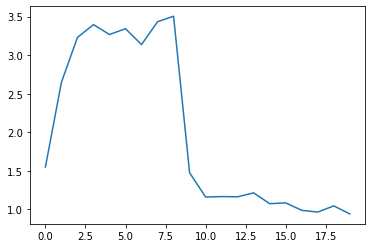

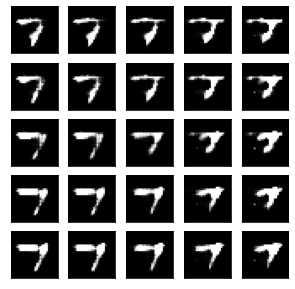

In [17]:
EPOCHS=20
history=train(train_dataset,EPOCHS)

plt.plot(history)
plt.show()
n=2
total=2*n+1

plt.figure(figsize=(total,total))
num=1
for i in range(-n,n+1):
    for j in range(-n,n+1):
        ax=plt.subplot(total,total,num)
        num+=1
        img=generator.predict(np.expand_dims([0.5*i/n,0.5*j/n],axis=0))
        plt.imshow(img[0,:,:,0],cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()      

